In [42]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys

import matplotlib.pyplot as plt

sys.path.append("../../../")
from src.athena import Athena
from src.utils import create_session

## Global

In [344]:
boto3_session = create_session(
    profile_name="dev",
    role_arn=os.getenv("ATHENA_IAM_ROLE_ARN"),
)

wait = True
ctas_approach = False

database = "balanced_tree"
tables = ["product_details", "product_hierarchy", "product_prices", "sales"]
sql_path = "../sql/"

athena = Athena(boto3_session=boto3_session, s3_output=os.getenv("ATHENA_S3_OUTPUT"))
athena

Athena(boto3_session=Session(region_name='us-east-1'), s3_output=s3://sql-case-studies/query_results)

## Problem Statement

Balanced Tree Clothing Company specializes in offering an optimized range of clothing and lifestyle wear tailored for the modern adventurer. 

The company's CEO, Danny, has requested an analysis of sales performance to assist the merchandising team in generating a financial report that can be shared with the broader business. This analysis will focus on key metrics and insights to support decision-making and strategic planning.

## Entity Relationship Diagram

<center>
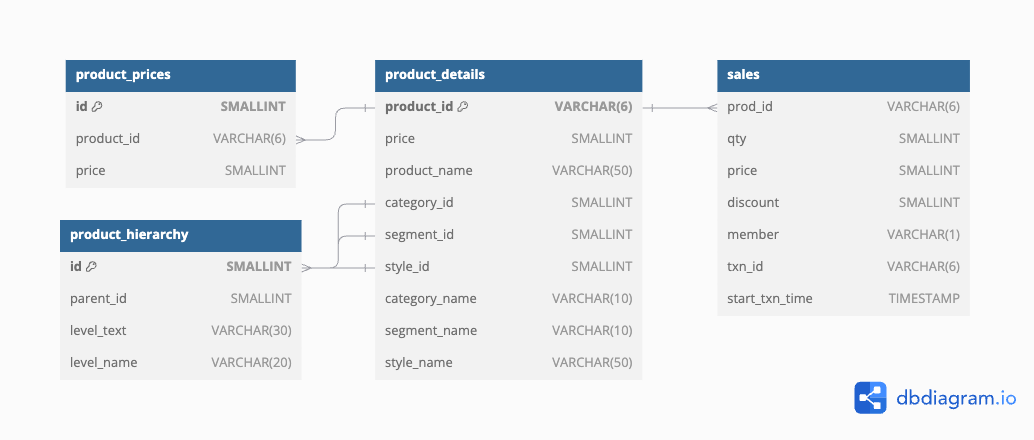
</center>

### Product Details

* **product_id**: Unique identifier for the product.  

* **price**: Price of the product in the store.  

* **product_name**: Name of the product.  

* **category_id**: Unique identifier for the category.  

* **segment_id**: Unique identifier for the segment.  

* **style_id**: Unique identifier for the style.  

* **category_name**: Name of the category.  

* **segment_name**: Name of the segment.  

* **style_name**: Name of the style.  

### Product Hierarchy

* **id**: Unique identifier for the entry in the hierarchy.  

* **parent_id**: Parent identifier for the current level (NULL for top-level categories).  

* **level_text**: Name or description of the hierarchy level (e.g., product type or style).  

* **level_name**: Name of the hierarchy level (e.g., Category, Segment, or Style).  

### Product Prices

* **id**: Unique identifier for the price record.  

* **product_id**: Unique identifier for the product.  

* **price**: Price of the product in the store.  

### Sales

* **prod_id**: Unique identifier for the product.  

* **qty**: Quantity of the product purchased in the transaction.  

* **price**: Price of the product in the transaction.  

* **discount**: Discount percentage applied to the product.  

* **member**: Membership status of the buyer (`t` for true, `f` for false).  

* **txn_id**: Unique identifier for the transaction.  

* **start_txn_time**: Timestamp of when the transaction started.  

## Tables

In [5]:
for table in tables:
    athena.query(
        database=database,
        query=f""" 
                SELECT
                    *
                FROM
                    {database}.{table} TABLESAMPLE BERNOULLI(30);
              """,
        ctas_approach=ctas_approach,
    )

,product_id,price,product_name,category_id,segment_id,style_id,category_name,segment_name,style_name
0,c4a632,13,Navy Oversized Jeans - Womens,1,3,7,Womens,Jeans,Navy Oversized
1,e31d39,10,Cream Relaxed Jeans - Womens,1,3,9,Womens,Jeans,Cream Relaxed
2,72f5d4,19,Indigo Rain Jacket - Womens,1,4,11,Womens,Jacket,Indigo Rain
3,9ec847,54,Grey Fashion Jacket - Womens,1,4,12,Womens,Jacket,Grey Fashion
4,c8d436,10,Teal Button Up Shirt - Mens,2,5,14,Mens,Shirt,Teal Button Up


,id,parent_id,level_text,level_name
0,1,<NA>,Womens,Category
1,3,1,Jeans,Segment
2,10,4,Khaki Suit,Style
3,13,5,White Tee,Style
4,17,6,White Striped,Style


,id,product_id,price
0,8,e83aa3,32
1,11,72f5d4,19
2,14,c8d436,10
3,15,2a2353,57
4,17,b9a74d,17


,prod_id,qty,price,discount,member,txn_id,start_txn_time
0,2feb6b,2,29,17,t,54f307,2021-02-13 01:59:43.296
1,f084eb,3,36,21,t,26cc98,2021-01-19 01:39:00.345
2,c4a632,1,13,21,f,ef648d,2021-01-27 02:18:17.164
3,5d267b,3,40,21,f,ef648d,2021-01-27 02:18:17.164
4,2feb6b,2,29,23,t,fba96f,2021-03-03 00:32:56.054
...,...,...,...,...,...,...,...
4464,2a2353,1,57,14,f,72cd63,2021-01-13 12:47:38.630
4465,f084eb,3,36,14,f,72cd63,2021-01-13 12:47:38.630
4466,c4a632,3,13,13,t,f15ab3,2021-03-20 12:01:22.944
4467,e83aa3,5,32,13,t,f15ab3,2021-03-20 12:01:22.944


## Sales Analysis

## Q1

What was the total quantity sold for all products?

In [20]:
query = """ 
SELECT
    s.prod_id,
    d.product_name,
    SUM(s.qty) AS total_qty
FROM
    balanced_tree.sales AS s
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    s.prod_id,
    d.product_name
ORDER BY
    total_qty DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,prod_id,product_name,total_qty
0,9ec847,Grey Fashion Jacket - Womens,3876
1,c4a632,Navy Oversized Jeans - Womens,3856
2,2a2353,Blue Polo Shirt - Mens,3819
3,5d267b,White Tee Shirt - Mens,3800
4,f084eb,Navy Solid Socks - Mens,3792
5,e83aa3,Black Straight Jeans - Womens,3786
6,2feb6b,Pink Fluro Polkadot Socks - Mens,3770
7,72f5d4,Indigo Rain Jacket - Womens,3757
8,d5e9a6,Khaki Suit Jacket - Womens,3752
9,e31d39,Cream Relaxed Jeans - Womens,3707


## Q2

What is the total generated revenue for all products before discounts?

In [15]:
query = """ 
SELECT
    FORMAT('$%,d', SUM(qty * price)) AS total_rev_before_discount
FROM
    balanced_tree.sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,total_rev_before_discount
0,"$1,289,453"


## Q3

What was the total discount amount for all products?

In [22]:
query = """ 
SELECT
    s.prod_id,
    d.product_name,
    SUM(s.qty * s.price * (s.discount / 100.0)) AS discount_amt
FROM
    balanced_tree.sales AS s 
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    s.prod_id,
    d.product_name
ORDER BY
    discount_amt DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,prod_id,product_name,discount_amt
0,2a2353,Blue Polo Shirt - Mens,26819.07
1,9ec847,Grey Fashion Jacket - Womens,25391.88
2,5d267b,White Tee Shirt - Mens,18377.60
3,f084eb,Navy Solid Socks - Mens,16650.36
4,e83aa3,Black Straight Jeans - Womens,14744.96
5,2feb6b,Pink Fluro Polkadot Socks - Mens,12952.27
6,d5e9a6,Khaki Suit Jacket - Womens,10243.05
7,72f5d4,Indigo Rain Jacket - Womens,8642.53
8,b9a74d,White Striped Socks - Mens,7410.81
9,c4a632,Navy Oversized Jeans - Womens,6135.61


In [25]:
query = """ 
SELECT
    FORMAT('$%,.2f', SUM(qty * price * (discount / 100.0))) AS total_discount_amt
FROM
    balanced_tree.sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,total_discount_amt
0,"$156,229.14"


## Transactions Analysis

## Q1

How many unique transactions were there?

In [26]:
query = """ 
SELECT
    COUNT(DISTINCT txn_id) AS transactions_count
FROM
    balanced_tree.sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,transactions_count
0,2500


## Q2

What is the average unique products purchased in each transaction?

In [29]:
query = """ 
WITH product_count_per_txn AS (
    SELECT
        txn_id,
        COUNT(DISTINCT prod_id) AS product_count
    FROM
        balanced_tree.sales
    GROUP BY
        txn_id
)
SELECT
    AVG(product_count) AS avg_unique_prod_per_txn
FROM
    product_count_per_txn;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,avg_unique_prod_per_txn
0,6.038


## Q3

What are the 25th, 50th and 75th percentile values for the revenue per transaction?

> **Note:** We consider the revenue after applying the discount.

In [56]:
query = """ 
WITH rev_per_txn AS (
    SELECT
        txn_id,
        SUM(
            qty * (price * (1 - (discount / 100.0)))
        ) AS rev
    FROM
        balanced_tree.sales
    GROUP BY
        txn_id
)
SELECT
    APPROX_PERCENTILE(rev, 0.25) AS pct_25,
    APPROX_PERCENTILE(rev, 0.50) AS pct_50,
    AVG(rev) AS avg,
    APPROX_PERCENTILE(rev, 0.75) AS pct_75
FROM
    rev_per_txn;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,pct_25,pct_50,avg,pct_75
0,327.416522,437.63246,453.289544,572.559528


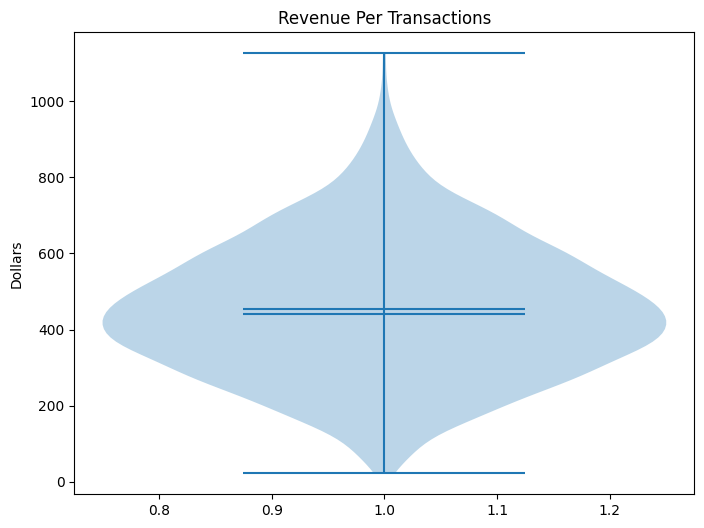

In [44]:
query = """ 
SELECT
    txn_id,
    SUM(
        qty * (price * (1 - (discount / 100.0)))
    ) AS rev
FROM
    balanced_tree.sales
GROUP BY
    txn_id;
"""

rev_per_txn = athena.query(database=database, query=query, ctas_approach=ctas_approach)[
    "rev"
].values


plt.figure(figsize=(8, 6))
plt.violinplot(rev_per_txn, showmeans=True, showextrema=True, showmedians=True)
plt.title("Revenue Per Transactions")
plt.ylabel("Dollars")
plt.show();

## Q4

What is the average discount value per transaction?

In [47]:
query = """ 
WITH discount_per_txn AS (
    SELECT
        txn_id,
        SUM(
            qty * (price * (discount / 100.0))
        ) AS discount
    FROM
        balanced_tree.sales
    GROUP BY
        txn_id
)
SELECT
    APPROX_PERCENTILE(discount, 0.25) AS pct_25,
    APPROX_PERCENTILE(discount, 0.50) AS pct_50,
    AVG(discount) AS avg,
    APPROX_PERCENTILE(discount, 0.75) AS pct_75
FROM
    discount_per_txn;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,pct_25,pct_50,avg,pct_75
0,25.514365,53.596724,62.491656,91.783839


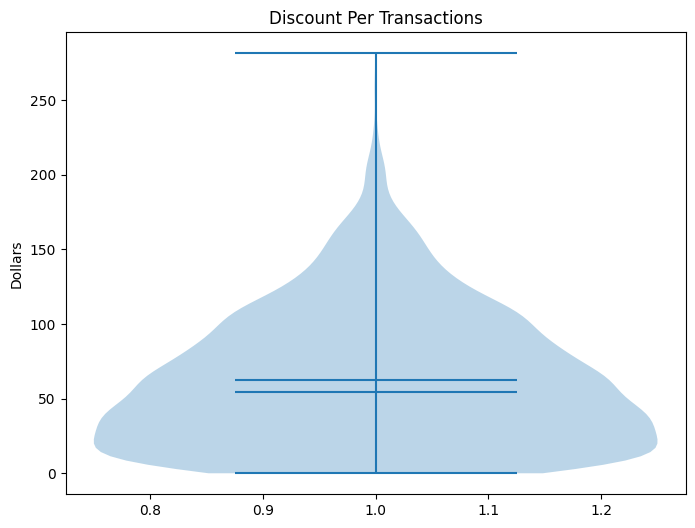

In [48]:
query = """ 
SELECT
    txn_id,
    SUM(
        qty * (price * (discount / 100.0))
    ) AS discount
FROM
    balanced_tree.sales
GROUP BY
    txn_id;
"""

discount_per_txn = athena.query(
    database=database, query=query, ctas_approach=ctas_approach
)["discount"].values


plt.figure(figsize=(8, 6))
plt.violinplot(discount_per_txn, showmeans=True, showextrema=True, showmedians=True)
plt.title("Discount Per Transactions")
plt.ylabel("Dollars")
plt.show();

## Q5

What is the percentage split of all transactions for members vs non-members?

In [59]:
query = """ 
SELECT
    SUM(CASE WHEN member = 't' THEN 1.0 ELSE 0.0 END) / COUNT(*) * 100.0 AS pct_member,
    SUM(CASE WHEN member = 'f' THEN 1.0 ELSE 0.0 END) / COUNT(*) * 100.0 AS pct_non_member
FROM
    balanced_tree.sales;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,pct_member,pct_non_member
0,60.026499,39.973501


## Q6

What is the average revenue for member transactions and non-member transactions?

In [77]:
query = """ 
WITH rev AS (
    SELECT
        member,
        txn_id,
        SUM(
            qty * (price * (1 - (discount / 100.0)))
        ) AS rev
    FROM
        balanced_tree.sales
    GROUP BY
        member,
        txn_id
)
SELECT
    member,
    AVG(rev) AS avg_rev
FROM
    rev
GROUP BY
    member;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,member,avg_rev
0,f,452.007769
1,t,454.136963


## Product Analysis

## Q1

What are the top 3 products by total revenue before discount?

> **Note:** We consider the revenue before applying the discount. Formatting is applied to the output but the calculations should be used in the `ORDER BY` clause instead of the formatted values.

In [88]:
query = """ 
SELECT
    s.prod_id,
    d.product_name,
    FORMAT('$%,d', SUM(s.qty * s.price)) AS total_rev
FROM
    balanced_tree.sales AS s
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    s.prod_id,
    d.product_name
ORDER BY
    SUM(s.qty * s.price) DESC
LIMIT 
    3;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,prod_id,product_name,total_rev
0,2a2353,Blue Polo Shirt - Mens,"$217,683"
1,9ec847,Grey Fashion Jacket - Womens,"$209,304"
2,5d267b,White Tee Shirt - Mens,"$152,000"


## Q2

What is the total quantity, revenue and discount for each segment?

In [98]:
query = """ 
SELECT
    d.segment_name,
    FORMAT('$%,d', SUM(s.qty * s.price)) AS total_rev,
    FORMAT('%,d', SUM(s.qty)) AS total_qty,
    FORMAT('$%,.2f', SUM(s.qty * s.price * (s.discount / 100.0))) AS total_discount
FROM
    balanced_tree.sales AS s
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    d.segment_name
ORDER BY
    d.segment_name;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,segment_name,total_rev,total_qty,total_discount
0,Jacket,"$366,983","11,385","$44,277.46"
1,Jeans,"$208,350","11,349","$25,343.97"
2,Shirt,"$406,143","11,265","$49,594.27"
3,Socks,"$307,977","11,217","$37,013.44"


## Q3

What is the top selling product for each segment?

In [148]:
def top_selling_prod_query(group_col: str, top_n: int) -> str:
    return f""" 
            WITH qty_sold AS (
                SELECT
                    d.{group_col},
                    d.product_name,
                    SUM(s.qty) AS qty_sold
                FROM
                    balanced_tree.sales AS s
                        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
                GROUP BY
                    d.{group_col},
                    d.product_name
            ),

            ranked_data AS (
                SELECT
                    {group_col},
                    product_name,
                    qty_sold,
                    DENSE_RANK() OVER(PARTITION BY {group_col} ORDER BY qty_sold DESC) AS ranks
                FROM
                    qty_sold
            )
            SELECT
                {group_col},
                product_name,
                qty_sold
            FROM
                ranked_data
            WHERE
                1 = 1
                AND ranks <= {top_n}
            ORDER BY
                {group_col},
                qty_sold DESC;
            """


athena.query(
    database=database,
    query=top_selling_prod_query("segment_name", 3),
    ctas_approach=ctas_approach,
)

,segment_name,product_name,qty_sold
0,Jacket,Grey Fashion Jacket - Womens,3876
1,Jacket,Indigo Rain Jacket - Womens,3757
2,Jacket,Khaki Suit Jacket - Womens,3752
3,Jeans,Navy Oversized Jeans - Womens,3856
4,Jeans,Black Straight Jeans - Womens,3786
5,Jeans,Cream Relaxed Jeans - Womens,3707
6,Shirt,Blue Polo Shirt - Mens,3819
7,Shirt,White Tee Shirt - Mens,3800
8,Shirt,Teal Button Up Shirt - Mens,3646
9,Socks,Navy Solid Socks - Mens,3792


## Q4

What is the total quantity, revenue and discount for each category?

In [117]:
query = """ 
SELECT
    d.category_name,
    FORMAT('$%,d', SUM(s.qty * s.price)) AS total_rev,
    FORMAT('%,d', SUM(s.qty)) AS total_qty,
    FORMAT('$%,.2f', SUM(s.qty * s.price * (s.discount / 100.0))) AS total_discount
FROM
    balanced_tree.sales AS s 
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    d.category_name
ORDER BY
    d.category_name DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,category_name,total_rev,total_qty,total_discount
0,Womens,"$575,333","22,734","$69,621.43"
1,Mens,"$714,120","22,482","$86,607.71"


## Q5

What is the top selling product for each category?

In [149]:
athena.query(
    database=database,
    query=top_selling_prod_query("category_name", 2),
    ctas_approach=ctas_approach,
)

,category_name,product_name,qty_sold
0,Mens,Blue Polo Shirt - Mens,3819
1,Mens,White Tee Shirt - Mens,3800
2,Womens,Grey Fashion Jacket - Womens,3876
3,Womens,Navy Oversized Jeans - Womens,3856


## Q6

What is the percentage split of revenue by product for each segment?

> **Note:** We consider the revenue after applying the discount.

In [164]:
def rev_pct_query(group_col_1: str, group_col_2: str) -> str:
    return f""" 
            WITH rev_data AS (
                SELECT
                    d.{group_col_1},
                    d.{group_col_2},
                    SUM(s.qty * (s.price * (1 - (s.discount / 100.0)))) AS rev
                FROM
                    balanced_tree.sales AS s
                        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
                GROUP BY
                    d.{group_col_1},
                    d.{group_col_2}
            )
            SELECT
                {group_col_1},
                {group_col_2},
                FORMAT('$%,.2f', rev) AS rev,
                CONCAT(
                    FORMAT('%.2f', ROUND((rev / SUM(rev) OVER(PARTITION BY {group_col_1})) * 100.0, 2)), 
                    '%'
                ) AS rev_pct_split
            FROM
                rev_data
            ORDER BY
                {group_col_1},
                {group_col_2};
            """


athena.query(
    database=database,
    query=rev_pct_query("segment_name", "product_name"),
    ctas_approach=ctas_approach,
)

,segment_name,product_name,rev,rev_pct_split
0,Jacket,Grey Fashion Jacket - Womens,"$183,912.12",56.99%
1,Jacket,Indigo Rain Jacket - Womens,"$62,740.47",19.44%
2,Jacket,Khaki Suit Jacket - Womens,"$76,052.95",23.57%
3,Jeans,Black Straight Jeans - Womens,"$106,407.04",58.14%
4,Jeans,Cream Relaxed Jeans - Womens,"$32,606.60",17.82%
5,Jeans,Navy Oversized Jeans - Womens,"$43,992.39",24.04%
6,Shirt,Blue Polo Shirt - Mens,"$190,863.93",53.53%
7,Shirt,Teal Button Up Shirt - Mens,"$32,062.40",8.99%
8,Shirt,White Tee Shirt - Mens,"$133,622.40",37.48%
9,Socks,Navy Solid Socks - Mens,"$119,861.64",44.24%


## Q7

What is the percentage split of revenue by segment for each category?

> **Note:** We consider the revenue after applying the discount.

In [165]:
athena.query(
    database=database,
    query=rev_pct_query("category_name", "segment_name"),
    ctas_approach=ctas_approach,
)

,category_name,segment_name,rev,rev_pct_split
0,Mens,Shirt,"$356,548.73",56.82%
1,Mens,Socks,"$270,963.56",43.18%
2,Womens,Jacket,"$322,705.54",63.81%
3,Womens,Jeans,"$183,006.03",36.19%


## Q8

What is the percentage split of total revenue by category?

> **Note:** We consider the revenue after applying the discount.

In [189]:
rev_formula = "s.qty * (s.price * (1 - (s.discount / 100.0)))"

query = f"""
SELECT
    d.category_name,
    FORMAT('$%,.2f', SUM({rev_formula})) AS rev,
    CONCAT(
        FORMAT(
            '%.2f',
            ROUND(SUM({rev_formula}) / SUM(SUM({rev_formula})) OVER() * 100.0, 2)
        ),
        '%'
    ) AS rev_pct_split
FROM
    balanced_tree.sales AS s
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    d.category_name;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,category_name,rev,rev_pct_split
0,Womens,"$505,711.57",44.63%
1,Mens,"$627,512.29",55.37%


## Q9

What is the total transaction "penetration" for each product? (hint: penetration = number of transactions where at least 1 quantity of a product was purchased divided by total number of transactions)

$$
\text{Penetration of Product $i$} = \frac{\text{Number of transactions in which at least 1 quantity of product $i$ was purchased}}{\text{Total number of transactions}}

In [229]:
query = """ 
SELECT
    s.prod_id,
    d.product_name,
    CONCAT(
        FORMAT('%.2f', TRY_CAST(COUNT(DISTINCT s.txn_id) AS DOUBLE) / TRY_CAST((SELECT COUNT(DISTINCT txn_id) FROM balanced_tree.sales) AS DOUBLE) * 100.0),
        '%'
    ) AS penetration
FROM
    balanced_tree.sales AS s
        LEFT JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    s.prod_id,
    d.product_name
ORDER BY
    TRY_CAST(COUNT(DISTINCT s.txn_id) AS DOUBLE) / TRY_CAST((SELECT COUNT(DISTINCT txn_id) FROM balanced_tree.sales) AS DOUBLE) DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,prod_id,product_name,penetration
0,f084eb,Navy Solid Socks - Mens,51.24%
1,9ec847,Grey Fashion Jacket - Womens,51.00%
2,c4a632,Navy Oversized Jeans - Womens,50.96%
3,2a2353,Blue Polo Shirt - Mens,50.72%
4,5d267b,White Tee Shirt - Mens,50.72%
5,2feb6b,Pink Fluro Polkadot Socks - Mens,50.32%
6,72f5d4,Indigo Rain Jacket - Womens,50.00%
7,d5e9a6,Khaki Suit Jacket - Womens,49.88%
8,e83aa3,Black Straight Jeans - Womens,49.84%
9,e31d39,Cream Relaxed Jeans - Womens,49.72%


### Double Pass CTE Approach

In [217]:
query = """ 
WITH txn_by_prod AS (
    SELECT 
        prod_id,
        COUNT(DISTINCT txn_id) AS txn_count_by_product
    FROM 
        balanced_tree.sales
    GROUP BY 
        prod_id
),

total_txn AS (
    SELECT
        COUNT(DISTINCT txn_id) AS total_txn_count
    FROM 
        balanced_tree.sales
)
SELECT
    d.product_id,
    d.product_name,
    CONCAT(
        FORMAT('%.2f', TRY_CAST(t.txn_count_by_product AS DOUBLE) / TRY_CAST(total_t.total_txn_count AS DOUBLE) * 100.0),
        '%'
    ) AS penetration
FROM 
    txn_by_prod AS t
        CROSS JOIN total_txn AS total_t
        INNER JOIN balanced_tree.product_details AS d ON t.prod_id = d.product_id
ORDER BY 
    TRY_CAST(t.txn_count_by_product AS DOUBLE) / TRY_CAST(total_t.total_txn_count AS DOUBLE) DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_id,product_name,penetration
0,f084eb,Navy Solid Socks - Mens,51.24%
1,9ec847,Grey Fashion Jacket - Womens,51.00%
2,c4a632,Navy Oversized Jeans - Womens,50.96%
3,2a2353,Blue Polo Shirt - Mens,50.72%
4,5d267b,White Tee Shirt - Mens,50.72%
5,2feb6b,Pink Fluro Polkadot Socks - Mens,50.32%
6,72f5d4,Indigo Rain Jacket - Womens,50.00%
7,d5e9a6,Khaki Suit Jacket - Womens,49.88%
8,e83aa3,Black Straight Jeans - Womens,49.84%
9,e31d39,Cream Relaxed Jeans - Womens,49.72%


This approach works because the result of the `total_txn` CTE is a single-row, single-column value (`total_txn_count`). When using a `CROSS JOIN`, also known as a Cartesian product, this value is matched with each row from the `txn_by_prod` CTE. This allows the single value from `total_txn` to be appended to every row in `txn_by_prod`, effectively making `total_txn_count` available for calculations or comparisons across all rows in `txn_by_prod`. 

1. **`txn_by_prod` CTE**:
   - Aggregates transaction counts by product (`prod_id`) and returns one row per product with its corresponding transaction count.
2. **`total_txn` CTE**:
   - Calculates the total number of distinct transactions across all products, resulting in a single scalar value.
3. **`CROSS JOIN`**:
   - Combines every row in `txn_by_prod` with the single value from `total_txn` (`total_txn_count`), ensuring that the total transaction count is appended to each product's row.

This approach effectively replicates the single result of `total_txn` across all rows of `txn_by_prod`. It is particularly useful for cases where the total value needs to be compared or used in calculations for each product.

In [221]:
query = """ 
WITH txn_by_prod AS (
    SELECT 
        prod_id,
        COUNT(DISTINCT txn_id) AS txn_count_by_product
    FROM 
        balanced_tree.sales
    GROUP BY 
        prod_id
),

total_txn AS (
    SELECT
        COUNT(DISTINCT txn_id) AS total_txn_count
    FROM 
        balanced_tree.sales
)
SELECT
    *
FROM
    txn_by_prod
        CROSS JOIN total_txn;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,prod_id,txn_count_by_product,total_txn_count
0,f084eb,1281,2500
1,c4a632,1274,2500
2,72f5d4,1250,2500
3,e83aa3,1246,2500
4,5d267b,1268,2500
5,2feb6b,1258,2500
6,c8d436,1242,2500
7,d5e9a6,1247,2500
8,2a2353,1268,2500
9,e31d39,1243,2500


## Q10

What is the most common combination of at least 1 quantity of any 3 products in a 1 single transaction?

### Step 1: Recursive CTE

Use a recursive CTE to build all unique 3‐product combinations from the `balanced_tree.product_details` table.

#### Base Case

The base case selects all unique products from the `product_details` table.

In [288]:
query = """ 
SELECT
    ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
    CAST(d.product_id AS VARCHAR)         AS product,
    1                                     AS product_counter
FROM 
    balanced_tree.product_details AS d;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,combo,product,product_counter
0,[c4a632],c4a632,1
1,[e83aa3],e83aa3,1
2,[e31d39],e31d39,1
3,[d5e9a6],d5e9a6,1
4,[72f5d4],72f5d4,1
5,[9ec847],9ec847,1
6,[5d267b],5d267b,1
7,[c8d436],c8d436,1
8,[2a2353],2a2353,1
9,[f084eb],f084eb,1


#### Recursive Step

The recursion will lead to a table with $\binom{n}{k}$ rows, where $n$ is the number of unique product IDs and $k$ is the number of products in each combination. 

For **each** of those existing combos (say it has 1 or 2 products right now), we try to **append** a **new** product to the combo if:

1. The new product ID is **greater** than the last product ID in the combo (`d.product_id > output_table.product`).
2. The current `product_counter` is still **less than 3**, so we don’t exceed 3‐product combos.

This ensures we only create **unique** combos (no duplicates and no reordering like `[P1, P2]` vs `[P2, P1]`, we always move "upward" in product IDs).

We stop when we reach **3** products in a combo:

1. Because we only keep recursing while `product_counter < 3`, we stop at combos of exactly **3** products.  
2. In the final `SELECT`, we filter `WHERE product_counter = 3` to get only those **complete** 3‐product combinations.

#### Example

Given products `A, B, C, D` sorted by ID, the base case yields **single‐product** combos:

<center>

| combo | product | product_counter |
|-------|---------|-----------------|
| [A]   | A       | 1               |
| [B]   | B       | 1               |
| [C]   | C       | 1               |
| [D]   | D       | 1               |

</center>

##### First Recursive Pass (from 1‐product to 2‐product combos)

- **Take** `[A], A, 1` and try to append each product ID **greater** than `A`:

  - Append `B` → `[A, B], B, 2`
  - Append `C` → `[A, C], C, 2`
  - Append `D` → `[A, D], D, 2`

- **Take** `[B], B, 1` and append each product ID **greater** than `B`:

  - `[B, C], C, 2`
  - `[B, D], D, 2`

- **Take** `[C], C, 1` and append each product ID **greater** than `C`:

  - `[C, D], D, 2`

- **Take** `[D], D, 1` → no greater IDs remain, so no new rows from `[D]`.

Now `output_table` has **all** 2‐product combos. The recursion continues because `product_counter < 3`:

<center>

| combo  | product | product_counter |
|--------|---------|-----------------|
| [A, B]  | B       | 2               |
| [A, C]  | C       | 2               |
| [A, D]  | D       | 2               |
| [B, C]  | C       | 2               |
| [B, D]  | D       | 2               |
| [C, D]  | D       | 2               |

</center>

##### Second Recursive Pass (from 2‐product to 3‐product combos)

- Start with `[A, B], B, 2`; append any product ID **greater** than `B`:
  - `[A, B, C], C, 3`
  - `[A, B, D], D, 3`
- `[A, C], C, 2`:  
  - `[A, C, D], D, 3`
- `[A, D], D, 2`:  
  - (No product greater than `D` → no new combo)
- `[B, C], C, 2`:  
  - `[B, C, D], D, 3`
- `[B, D], D, 2`:  
  - (No product greater than `D`)
- `[C, D], D, 2`:  
  - (No product greater than `D`)

Now we have **3‐product combos**:

<center>

| combo    | product | product_counter |
|----------|---------|-----------------|
| [A, B, C]  | C       | 3               |
| [A, B, D]  | D       | 3               |
| [A, C, D]  | D       | 3               |
| [B, C, D]  | D       | 3               |

</center>

Because `product_counter` is now `3`, we **stop** the recursion. 

#### Why Does the `d.product_id > output_table.product` Condition Remove Duplicates?

- That condition ensures that each **next** product has a strictly **higher** ID (i.e., by **lexicographical ordering**) than the last appended product, so we never pick the same product twice and never produce the same combo in a different order.  
- For example, if we already have `[A]`, we only add `B, C, D` if `B > A`, `C > A`, and so on. We never go back and pair `[B, A]`, so duplicated combos are avoided.

In [297]:
query = """ 
WITH RECURSIVE output_table (combo, product, product_counter) AS (

    -- === 1) BASE CASE ===

    SELECT
        ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)         AS product,
        1                                     AS product_counter
    FROM 
        balanced_tree.product_details AS d

    UNION ALL

    -- === 2) RECURSIVE STEP ===

    SELECT
        output_table.combo || ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)                               AS product,
        output_table.product_counter + 1                            AS product_counter
    FROM 
        output_table 
        INNER JOIN balanced_tree.product_details AS d ON d.product_id > output_table.product
    WHERE 
        output_table.product_counter < 3
)

SELECT 
    *
FROM 
    output_table
WHERE 
    product_counter = 3;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,combo,product,product_counter
0,"[5d267b, 72f5d4, c4a632]",c4a632,3
1,"[2a2353, 72f5d4, c4a632]",c4a632,3
2,"[2feb6b, 72f5d4, c4a632]",c4a632,3
3,"[72f5d4, 9ec847, c4a632]",c4a632,3
4,"[5d267b, 9ec847, c4a632]",c4a632,3
...,...,...,...
215,"[2a2353, 9ec847, b9a74d]",b9a74d,3
216,"[2feb6b, 9ec847, b9a74d]",b9a74d,3
217,"[2a2353, 5d267b, b9a74d]",b9a74d,3
218,"[2feb6b, 5d267b, b9a74d]",b9a74d,3


### Step 2: Gather Each Transaction’s Products

Create a table that groups `products_id` by `txn_id` into an array. In other words, for each transaction, we will have an array of the products purchased in that transaction.

In [298]:
query = """ 
SELECT
    txn_id,
    ARRAY_AGG(CAST(s.prod_id AS VARCHAR)) AS products
FROM 
    balanced_tree.sales AS s
GROUP BY 
    txn_id;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,txn_id,products
0,ef648d,"[c4a632, e83aa3, d5e9a6, 72f5d4, 5d267b, f084e..."
1,e9a1dd,"[72f5d4, 9ec847, 2a2353, f084eb]"
2,cf6517,"[d5e9a6, 72f5d4, 5d267b, b9a74d]"
3,47251d,"[72f5d4, 5d267b, 2a2353, f084eb]"
4,c75ea6,"[e83aa3, e31d39, 72f5d4, 9ec847, 5d267b, f084e..."
...,...,...
2495,08000a,"[c4a632, d5e9a6, 9ec847, 2a2353, f084eb, b9a74d]"
2496,5efab7,"[c4a632, d5e9a6, 5d267b, 2a2353, f084eb, b9a74d]"
2497,f905a2,"[e31d39, d5e9a6, 72f5d4, 9ec847, 5d267b, c8d43..."
2498,ba59c1,"[c4a632, e83aa3, 72f5d4, 9ec847, 5d267b, c8d43..."


### Step 3: Identify Transactions That Contain Each 3‐Product Combo (`cte_combo_transactions`)

#### Cartesian Product to Pair Each Transaction with Each 3‐Product Combo

We `CROSS JOIN` the 3‐product combos with the transactions CTE above, then filter for transactions that contain all 3 products. This essentially pairs each transaction with each 3‐product combo, allowing us to check if the transaction contains all 3 products in the combo.

#### Set Intersection to Check Containment

Since Athena/Trino do not support the `<@` array operator (Postgres‐only), we check containment using the `CARDINALITY(ARRAY_INTERSECT(...))` trick.

* The function `CARDINALITY(X)` returns the cardinality (size) of the array `X`.

* The function `ARRAY_INTERSECT(A, B)` returns an array of the elements in the intersection of arrays `A` and `B`, without duplicates.

If the cardinality of the intersection of the transaction’s products and the 3‐product combo is **3**, then the transaction contains all 3 products in the combo.

In [299]:
query = """ 
WITH RECURSIVE output_table (combo, product, product_counter) AS (

    -- === 1) BASE CASE ===

    SELECT
        ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)         AS product,
        1                                     AS product_counter
    FROM 
        balanced_tree.product_details AS d

    UNION ALL

    -- === 2) RECURSIVE STEP ===

    SELECT
        output_table.combo || ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)                               AS product,
        output_table.product_counter + 1                            AS product_counter
    FROM 
        output_table 
        INNER JOIN balanced_tree.product_details AS d ON d.product_id > output_table.product
    WHERE 
        output_table.product_counter < 3
),

cte_transaction_products (txn_id, products) AS (
    SELECT
        txn_id,
        ARRAY_AGG(CAST(s.prod_id AS VARCHAR)) AS products
    FROM 
        balanced_tree.sales AS s
    GROUP BY 
        txn_id
)

SELECT
    tp.txn_id,
    combos.combo,
    tp.products
FROM 
    cte_transaction_products AS tp
    CROSS JOIN (
        SELECT 
            combo
        FROM 
            output_table
        WHERE 
            product_counter = 3
    ) AS combos (combo)
WHERE 
    CARDINALITY(ARRAY_INTERSECT(combos.combo, tp.products)) = CARDINALITY(combos.combo);
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,txn_id,combo,products
0,9a36b3,"[5d267b, 72f5d4, c4a632]","[c4a632, e83aa3, e31d39, 72f5d4, 9ec847, 5d267..."
1,f4dfc4,"[5d267b, 72f5d4, c4a632]","[c4a632, 72f5d4, 5d267b, 2a2353]"
2,d044e6,"[5d267b, 72f5d4, c4a632]","[c4a632, e83aa3, 72f5d4, 5d267b, c8d436, f084eb]"
3,84d86c,"[5d267b, 72f5d4, c4a632]","[c4a632, e83aa3, d5e9a6, 72f5d4, 5d267b, c8d43..."
4,4bb50e,"[5d267b, 72f5d4, c4a632]","[c4a632, e31d39, 72f5d4, 5d267b, f084eb, 2feb6b]"
...,...,...,...
69438,f1c999,"[2a2353, d5e9a6, f084eb]","[e83aa3, e31d39, d5e9a6, 9ec847, 2a2353, f084e..."
69439,f1c999,"[2feb6b, d5e9a6, f084eb]","[e83aa3, e31d39, d5e9a6, 9ec847, 2a2353, f084e..."
69440,f1c999,"[2a2353, 9ec847, f084eb]","[e83aa3, e31d39, d5e9a6, 9ec847, 2a2353, f084e..."
69441,f1c999,"[2feb6b, 9ec847, f084eb]","[e83aa3, e31d39, d5e9a6, 9ec847, 2a2353, f084e..."


### Step 4: Rank Each 3‐Product Combo by Frequency (`cte_ranked_combos`)

Count how many transactions each combo appears in and rank them from most frequent to least frequent.

* Group by the 3‐product combo

    - Count the number of transactions each combo appears in

    - Rank the combos by frequency by ordering the count above in descending order

In [300]:
query = """ 
WITH RECURSIVE output_table (combo, product, product_counter) AS (

    -- === 1) BASE CASE ===

    SELECT
        ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)         AS product,
        1                                     AS product_counter
    FROM 
        balanced_tree.product_details AS d

    UNION ALL

    -- === 2) RECURSIVE STEP ===

    SELECT
        output_table.combo || ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)                               AS product,
        output_table.product_counter + 1                            AS product_counter
    FROM 
        output_table 
        INNER JOIN balanced_tree.product_details AS d ON d.product_id > output_table.product
    WHERE 
        output_table.product_counter < 3
),

cte_transaction_products (txn_id, products) AS (
    SELECT
        txn_id,
        ARRAY_AGG(CAST(s.prod_id AS VARCHAR)) AS products
    FROM 
        balanced_tree.sales AS s
    GROUP BY 
        txn_id
),

cte_combo_transactions (txn_id, combo, products) AS (
    SELECT
        tp.txn_id,
        combos.combo,
        tp.products
    FROM 
        cte_transaction_products AS tp
        CROSS JOIN (
            SELECT 
                combo
            FROM 
                output_table
            WHERE 
                product_counter = 3
        ) AS combos (combo)
    WHERE 
        CARDINALITY(ARRAY_INTERSECT(combos.combo, tp.products)) = CARDINALITY(combos.combo)
)

SELECT
    combo,
    COUNT(DISTINCT txn_id) AS transaction_count,
    RANK() OVER (ORDER BY COUNT(DISTINCT txn_id) DESC) AS combo_rank
FROM 
    cte_combo_transactions
GROUP BY 
    combo;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,combo,transaction_count,combo_rank
0,"[5d267b, 9ec847, c8d436]",352,1
1,"[72f5d4, e83aa3, f084eb]",349,2
2,"[5d267b, c4a632, c8d436]",347,3
3,"[2a2353, 9ec847, c8d436]",347,3
4,"[2a2353, 9ec847, b9a74d]",347,3
...,...,...,...
215,"[2feb6b, 5d267b, e31d39]",290,216
216,"[2feb6b, 72f5d4, d5e9a6]",289,217
217,"[5d267b, b9a74d, e31d39]",288,218
218,"[72f5d4, c4a632, d5e9a6]",287,219


### Step 5: UNNEST the Most Common Combo into Row Format (`cte_most_common_combo_product_transactions`)

We only want rows for the top‐ranked (i.e., `rank = 1`) combo(s). We [UNNEST](https://trino.io/docs/current/sql/select.html#unnest) that 3‐product array into 3 separate rows **for every transaction that contains it**.

- **`cte_combo_transactions combos`** has one row per transaction **per 3‐product combo** that appears in that transaction.  
- **`ranks.combo`** is the top‐ranked 3‐product array.  
- **`UNNEST(ranks.combo) AS t(prod_id)`** splits that 3‐product array into **3 separate rows**, one for each product ID in the combo.

If there are **N** transactions that have the top 3‐product combo, we’ll end up with **3 × N** rows, since each transaction row is “exploded” into 3 product rows. 

```text
  352 transactions
×   3 products in the combo
---------------------------
= 1056 total rows
```

**In other words**, each transaction that has the top 3‐product combo will produce exactly 3 rows in this step, one row per product ID in the combo.

In [301]:
query = """ 
WITH RECURSIVE output_table (combo, product, product_counter) AS (

    -- === 1) BASE CASE ===

    SELECT
        ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)         AS product,
        1                                     AS product_counter
    FROM 
        balanced_tree.product_details AS d

    UNION ALL

    -- === 2) RECURSIVE STEP ===

    SELECT
        output_table.combo || ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)                               AS product,
        output_table.product_counter + 1                            AS product_counter
    FROM 
        output_table 
        INNER JOIN balanced_tree.product_details AS d ON d.product_id > output_table.product
    WHERE 
        output_table.product_counter < 3
),

cte_transaction_products (txn_id, products) AS (
    SELECT
        txn_id,
        ARRAY_AGG(CAST(s.prod_id AS VARCHAR)) AS products
    FROM 
        balanced_tree.sales AS S
    GROUP BY 
        txn_id
),

cte_combo_transactions (txn_id, combo, products) AS (
    SELECT
        tp.txn_id,
        combos.combo,
        tp.products
    FROM 
        cte_transaction_products AS tp
        CROSS JOIN (
            SELECT 
                combo
            FROM 
                output_table
            WHERE 
                product_counter = 3
        ) AS combos (combo)
    WHERE 
        CARDINALITY(ARRAY_INTERSECT(combos.combo, tp.products)) = CARDINALITY(combos.combo)
),

cte_ranked_combos (combo, transaction_count, combo_rank) AS (
    SELECT
        combo,
        COUNT(DISTINCT txn_id) AS transaction_count,
        RANK() OVER (ORDER BY COUNT(DISTINCT txn_id) DESC) AS combo_rank
    FROM 
        cte_combo_transactions
    GROUP BY 
        combo
)

SELECT
    cct.txn_id,
    t.prod_id
FROM 
    cte_combo_transactions AS cct
    INNER JOIN cte_ranked_combos AS crc ON cct.combo = crc.combo
    CROSS JOIN UNNEST(crc.combo) AS t(prod_id)
WHERE 
    crc.combo_rank = 1;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,txn_id,prod_id
0,dfec5f,5d267b
1,dfec5f,9ec847
2,dfec5f,c8d436
3,28d244,5d267b
4,28d244,9ec847
...,...,...
1051,f77659,9ec847
1052,f77659,c8d436
1053,72cd63,5d267b
1054,72cd63,9ec847


### Step 6: Final Calculation (Quantity, Revenue, Discount, Net Revenue)

Join the transactions from Step 5 to the `balanced_tree.sales` table and `balanced_tree.product_details` to calculate final metrics:

In [311]:
query = """ 
WITH RECURSIVE output_table (combo, product, product_counter) AS (

    -- === 1) BASE CASE ===

    SELECT
        ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)         AS product,
        1                                     AS product_counter
    FROM 
        balanced_tree.product_details AS d

    UNION ALL

    -- === 2) RECURSIVE STEP ===

    SELECT
        output_table.combo || ARRAY[CAST(d.product_id AS VARCHAR)]  AS combo,
        CAST(d.product_id AS VARCHAR)                               AS product,
        output_table.product_counter + 1                            AS product_counter
    FROM 
        output_table 
        INNER JOIN balanced_tree.product_details AS d ON d.product_id > output_table.product
    WHERE 
        output_table.product_counter < 3
),

cte_transaction_products (txn_id, products) AS (
    SELECT
        txn_id,
        ARRAY_AGG(CAST(s.prod_id AS VARCHAR)) AS products
    FROM 
        balanced_tree.sales AS s
    GROUP BY 
        txn_id
),

cte_combo_transactions (txn_id, combo, products) AS (
    SELECT
        tp.txn_id,
        combos.combo,
        tp.products
    FROM 
        cte_transaction_products AS tp
        CROSS JOIN (
            SELECT 
                combo
            FROM 
                output_table
            WHERE 
                product_counter = 3
        ) AS combos (combo)
    WHERE 
        CARDINALITY(ARRAY_INTERSECT(combos.combo, tp.products)) = CARDINALITY(combos.combo)
),

cte_ranked_combos (combo, transaction_count, combo_rank) AS (
    SELECT
        combo,
        COUNT(DISTINCT txn_id)                                  AS transaction_count,
        RANK() OVER (ORDER BY COUNT(DISTINCT txn_id) DESC)      AS combo_rank
    FROM 
        cte_combo_transactions
    GROUP BY 
        combo
),

cte_most_common_combo_product_transactions (txn_id, prod_id) AS (
    SELECT
        cct.txn_id,
        t.prod_id
    FROM 
        cte_combo_transactions AS cct
        INNER JOIN cte_ranked_combos AS crc ON cct.combo = crc.combo
        CROSS JOIN UNNEST(crc.combo) AS t(prod_id)
    WHERE 
        crc.combo_rank = 1
)

SELECT
    d.product_id                                                                    AS product_id,
    d.product_name                                                                  AS product_name,
    COUNT(DISTINCT s.txn_id)                                                        AS combo_transaction_count,
    SUM(s.qty)                                                                      AS quantity,
    FORMAT('$%,d', ROUND(SUM(s.qty * s.price), 2))                                  AS revenue_after_discount,
    FORMAT('$%,.2f', ROUND(SUM(s.qty * s.price * (s.discount / 100.0)), 2))         AS discount,
    FORMAT('$%,.2f', ROUND(SUM(s.qty * s.price * (1 - s.discount / 100.0)), 2))     AS net_revenue
FROM 
    balanced_tree.sales AS s
    INNER JOIN cte_most_common_combo_product_transactions AS top_combo ON s.txn_id = top_combo.txn_id AND s.prod_id = top_combo.prod_id
    INNER JOIN balanced_tree.product_details AS d ON s.prod_id = d.product_id
GROUP BY
    d.product_id,
    d.product_name
ORDER BY
    combo_transaction_count DESC,
    d.product_id ASC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_id,product_name,combo_transaction_count,quantity,revenue_after_discount,discount,net_revenue
0,5d267b,White Tee Shirt - Mens,352,1007,"$40,280","$5,049.20","$35,230.80"
1,9ec847,Grey Fashion Jacket - Womens,352,1062,"$57,348","$6,997.86","$50,350.14"
2,c8d436,Teal Button Up Shirt - Mens,352,1054,"$10,540","$1,325.30","$9,214.70"


## Bonus Challenge

Use a single SQL query to transform the `product_hierarchy` and `product_prices` datasets to the `product_details` table.

### Step 1: Recursive CTE to Build the Hierarchy

#### Base Case

The base case initializes the recursion by selecting the top-level categories in the hierarchy (where `parent_id IS NULL`):

- We select only rows whose `parent_id IS NULL`.  

- These correspond to **top‐level nodes**--- **Categories**.  

- For each such row:  

  - `id` and `category_id` are set to the same `ph.id` (since it’s a **Category** node).  

  - `segment_id` and `style_id` are **NULL** (not yet assigned).  

  - `category_name` is `ph.level_text` (the name of this Category), while `segment_name` and `style_name` are **NULL**.  
  
This yields a **starting table** (`output_table`) with one row per **Category**.  

In [328]:
query = """ 
SELECT
    id,
    id AS category_id,
    CAST(NULL AS INTEGER) AS segment_id,
    CAST(NULL AS INTEGER) AS style_id,
    level_text AS category_name,
    CAST(NULL AS VARCHAR) AS segment_name,  
    CAST(NULL AS VARCHAR) AS style_name   
FROM
    balanced_tree.product_hierarchy
WHERE
    parent_id IS NULL;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,id,category_id,segment_id,style_id,category_name,segment_name,style_name
0,1,1,<NA>,<NA>,Womens,<NA>,<NA>
1,2,2,<NA>,<NA>,Mens,<NA>,<NA>


#### Recursive Step

After the base case, the query **unions** the above with its **recursive step**:

1. **Match each existing row in `output_table`** to its child nodes by joining on `output_table.id = child.parent_id`:

   - Think of `output_table.id` as the “current node” in the hierarchy.  

   - The `child` rows are the ones in `product_hierarchy` table whose `parent_id` matches that “current node.”

2. **For each child** we find, **create a new row** in the recursive output:

   - `child.id` becomes the **new** `id`.  

   - We **inherit** the existing `category_id` from the parent row in `output_table`, because all descendants of that top‐level node belong to the same Category.

   - If the `child.level_name` is `'Segment'`, we assign `segment_id = child.id`. Otherwise, we keep the same `segment_id` from the parent row (since we haven’t reached a segment yet).

   - If the `child.level_name` is `'Style'`, we assign `style_id = child.id`. Otherwise, we keep the parent row’s `style_id`.

   - Similarly for names:  

     - If `child.level_name = 'Segment'`, we overwrite `segment_name` with `child.level_text`.  

     - If `child.level_name = 'Style'`, we overwrite `style_name`.  

     - Everything else stays inherited from the parent row.

3. **Repeat** this step **recursively**, starting from the new rows we just generated. Each child row can itself be a parent to deeper nodes (grandchildren, great‐grandchildren, etc.) as long as there is a `parent_id` link.


##### Example

Imagine a simplified `product_hierarchy`:

<center>

| id | parent_id | level_name | level_text |
|----|-----------|------------|------------|
| 1  | NULL      | Category   | Men        |
| 2  | NULL      | Category   | Women      |
| 3  | 1         | Segment    | Shirts     |
| 4  | 3         | Style      | Casual     |
| 5  | 3         | Style      | Formal     |
| 6  | 1         | Segment    | Pants      |
| 7  | 6         | Style      | Denim      |

</center>

##### Base Case

We grab rows where `parent_id IS NULL`, i.e. `id = 1` (“Men”) and `id = 2` (“Women”). So **initially**, `output_table` has:

<center>

| id | category_id | segment_id | style_id | category_name | segment_name | style_name |
|----|-------------|------------|----------|---------------|--------------|------------|
| 1  | 1           | NULL       | NULL     | Men           | NULL         | NULL       |
| 2  | 2           | NULL       | NULL     | Women         | NULL         | NULL       |

</center>

##### 1st Recursive Pass

- Take `id = 1` (Men) from `output_table`; find all children: rows in `product_hierarchy` with `parent_id = 1`.  

  - We see `id = 3 (Shirts)` and `id = 6 (Pants)`. Both are `Segment` level.  

  - That yields:

<center>

  | child.id | child.level_name | child.level_text |
  |----------|------------------|-------------------|
  | 3        | Segment          | Shirts           |
  | 6        | Segment          | Pants            |

</center>

  For each, we create a row:

  - For child=3 ("Shirts"):  

    - `id = 3`  
    - `category_id` = 1 (inherited from parent)  
    - `segment_id = 3` (since `child.level_name = 'Segment'`)  
    - `style_id = NULL` (unchanged)  
    - `category_name = 'Men'` (inherited)  
    - `segment_name = 'Shirts'` (assigned because `'Segment'`)  
    - `style_name = NULL`  

  - For child=6 ("Pants"):  

    - `id = 6`  
    - `category_id` = 1  
    - `segment_id = 6`  
    - `style_id = NULL`  
    - `category_name = 'Men'`  
    - `segment_name = 'Pants'`  
    - `style_name = NULL`

- Take `id = 2` (Women); find all children: rows with `parent_id = 2`. 

  - Suppose we have none. Then no new rows come from `id = 2`.

Now `output_table` also includes these **new** rows:

<center>

| id | category_id | segment_id | style_id | category_name | segment_name | style_name |
|----|-------------|------------|----------|---------------|--------------|------------|
| 3  | 1           | 3          | NULL     | Men           | Shirts       | NULL       |
| 6  | 1           | 6          | NULL     | Men           | Pants        | NULL       |

</center>

##### 2nd Recursive Pass

- Consider the new row `id = 3 (Segment = Shirts)`. Look for children where `parent_id = 3`.  
  - Found `id = 4 (Style = Casual)`, `id = 5 (Style = Formal)`.  
  - Each yields new rows:

<center>

  | id | category_id | segment_id | style_id | category_name | segment_name | style_name |
  |----|-------------|------------|----------|---------------|--------------|------------|
  | 4  | 1           | 3          | 4        | Men           | Shirts       | Casual     |
  | 5  | 1           | 3          | 5        | Men           | Shirts       | Formal     |

</center>

- Consider the new row `id = 6` (Segment=Pants). Look for children where `parent_id = 6`.  
  - Found `id = 7 (Style = Denim)`:

<center>

  | id | category_id | segment_id | style_id | category_name | segment_name | style_name |
  |----|-------------|------------|----------|---------------|--------------|------------|
  | 7  | 1           | 6          | 7        | Men           | Pants        | Denim      |

</center>

- If `id = 2 (Women)` had children, we’d generate those as well, continuing the same pattern.

Eventually, once we have **no more children** for any newly added row, the recursion stops.

**End result**:  

For **every node** in the hierarchy, we get **one row** containing:

- The node’s **own** `id` (whether it’s a Category, Segment, or Style).  
- The “inherited” `category_id`, `segment_id`, `style_id`.  
- The “inherited” names for category, segment, style up to this point in the tree.


In [355]:
query = """ 
WITH RECURSIVE output_table (
    id, 
    category_id, 
    segment_id, 
    style_id, 
    category_name, 
    segment_name, 
    style_name
) AS (

  -- 1) BASE CASE

  SELECT
      ph.id,
      ph.id AS category_id,
      CAST(NULL AS INTEGER) AS segment_id,
      CAST(NULL AS INTEGER) AS style_id,
      ph.level_text AS category_name,
      CAST(NULL AS VARCHAR) AS segment_name,  
      CAST(NULL AS VARCHAR) AS style_name    
  FROM 
      balanced_tree.product_hierarchy AS ph
  WHERE 
      parent_id IS NULL

  UNION ALL

  -- 2) RECURSIVE STEP

  SELECT
      child.id,
      output_table.category_id,
      
      -- Assign segment_id if the child belongs to a category

      CASE
        WHEN child.level_name = 'Segment' THEN child.id
        ELSE output_table.segment_id
      END AS segment_id,

      -- Assign style_id if the child belongs to a segment

      CASE
        WHEN child.level_name = 'Style' THEN child.id
        ELSE output_table.style_id
      END AS style_id,

      output_table.category_name,

      -- Assign segment_name

      CASE
        WHEN child.level_name = 'Segment' THEN child.level_text
        ELSE output_table.segment_name
      END AS segment_name,

      -- Assign style_name

      CASE
        WHEN child.level_name = 'Style' THEN child.level_text
        ELSE output_table.style_name
      END AS style_name
  FROM 
      output_table INNER JOIN balanced_tree.product_hierarchy AS child ON output_table.id = child.parent_id
)

SELECT
    * 
FROM
    output_table;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,id,category_id,segment_id,style_id,category_name,segment_name,style_name
0,1,1,<NA>,<NA>,Womens,<NA>,<NA>
1,2,2,<NA>,<NA>,Mens,<NA>,<NA>
2,4,1,4,<NA>,Womens,Jacket,<NA>
3,3,1,3,<NA>,Womens,Jeans,<NA>
4,6,2,6,<NA>,Mens,Socks,<NA>
5,5,2,5,<NA>,Mens,Shirt,<NA>
6,12,1,4,12,Womens,Jacket,Grey Fashion
7,11,1,4,11,Womens,Jacket,Indigo Rain
8,10,1,4,10,Womens,Jacket,Khaki Suit
9,9,1,3,9,Womens,Jeans,Cream Relaxed


### Step 2: Join with `product_prices` to Get the Final `product_details` Table

- For each row in the hierarchy (each node), match it with its `price` from `product_prices`.

- Build a `product_name` by concatenating `style_name - segment_name - category_name` (in that order), or skipping NULL parts if `style_name` or `segment_name` were never set.

In [354]:
query = """ 
WITH RECURSIVE output_table (
    id, 
    category_id, 
    segment_id, 
    style_id, 
    category_name, 
    segment_name, 
    style_name
) AS (

  -- 1) BASE CASE

  SELECT
      ph.id,
      ph.id AS category_id,
      CAST(NULL AS INTEGER) AS segment_id,
      CAST(NULL AS INTEGER) AS style_id,
      ph.level_text AS category_name,
      CAST(NULL AS VARCHAR) AS segment_name,  
      CAST(NULL AS VARCHAR) AS style_name    
  FROM 
      balanced_tree.product_hierarchy AS ph
  WHERE 
      parent_id IS NULL

  UNION ALL

  -- 2) RECURSIVE STEP

  SELECT
      child.id,
      output_table.category_id,
      
      -- Assign segment_id if the child belongs to a category

      CASE
        WHEN child.level_name = 'Segment' THEN child.id
        ELSE output_table.segment_id
      END AS segment_id,

      -- Assign style_id if the child belongs to a segment

      CASE
        WHEN child.level_name = 'Style' THEN child.id
        ELSE output_table.style_id
      END AS style_id,

      output_table.category_name,

      -- Assign segment_name

      CASE
        WHEN child.level_name = 'Segment' THEN child.level_text
        ELSE output_table.segment_name
      END AS segment_name,

      -- Assign style_name

      CASE
        WHEN child.level_name = 'Style' THEN child.level_text
        ELSE output_table.style_name
      END AS style_name
  FROM 
      output_table INNER JOIN balanced_tree.product_hierarchy AS child ON output_table.id = child.parent_id
)

-- 3) Final Select: Join with prices and generate product_name

SELECT
    pp.product_id,
    pp.price,
    CONCAT_WS(' - ', style_name, segment_name, category_name) AS product_name,
    category_id,
    segment_id,
    style_id,
    category_name,
    segment_name,
    style_name
FROM 
    output_table INNER JOIN balanced_tree.product_prices AS pp ON output_table.id = pp.id
ORDER BY
    price DESC;
"""

athena.query(database=database, query=query, ctas_approach=ctas_approach)

,product_id,price,product_name,category_id,segment_id,style_id,category_name,segment_name,style_name
0,2a2353,57,Blue Polo - Shirt - Mens,2,5,15,Mens,Shirt,Blue Polo
1,9ec847,54,Grey Fashion - Jacket - Womens,1,4,12,Womens,Jacket,Grey Fashion
2,5d267b,40,White Tee - Shirt - Mens,2,5,13,Mens,Shirt,White Tee
3,f084eb,36,Navy Solid - Socks - Mens,2,6,16,Mens,Socks,Navy Solid
4,e83aa3,32,Black Straight - Jeans - Womens,1,3,8,Womens,Jeans,Black Straight
5,2feb6b,29,Pink Fluro Polkadot - Socks - Mens,2,6,18,Mens,Socks,Pink Fluro Polkadot
6,d5e9a6,23,Khaki Suit - Jacket - Womens,1,4,10,Womens,Jacket,Khaki Suit
7,72f5d4,19,Indigo Rain - Jacket - Womens,1,4,11,Womens,Jacket,Indigo Rain
8,b9a74d,17,White Striped - Socks - Mens,2,6,17,Mens,Socks,White Striped
9,c4a632,13,Navy Oversized - Jeans - Womens,1,3,7,Womens,Jeans,Navy Oversized
